# Tikhonov regularization

In this notebook we are going to predict the aggregated popularity, revenue and budget for actors using Tikhonov Regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import pyunlocbox
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from project_utils import *
from pygsp import graphs, plotting

In [2]:
seed = 42
actors_agg_adj = np.load("sparse_agg_actor_adj.npy")
actors_dataset_df = pd.read_pickle("actors_dataset_df.pkl")
G = graphs.Graph(actors_agg_adj)
G.set_coordinates(kind="spring",seed=seed)

In [3]:
budget_signal = actors_dataset_df["budget"]
popularity_signal = actors_dataset_df["popularity"]
vote_average_signal = actors_dataset_df["vote_average"]
revenue_signal = actors_dataset_df["revenue"]

## Budget signal

/Users/adrianvillarroel/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


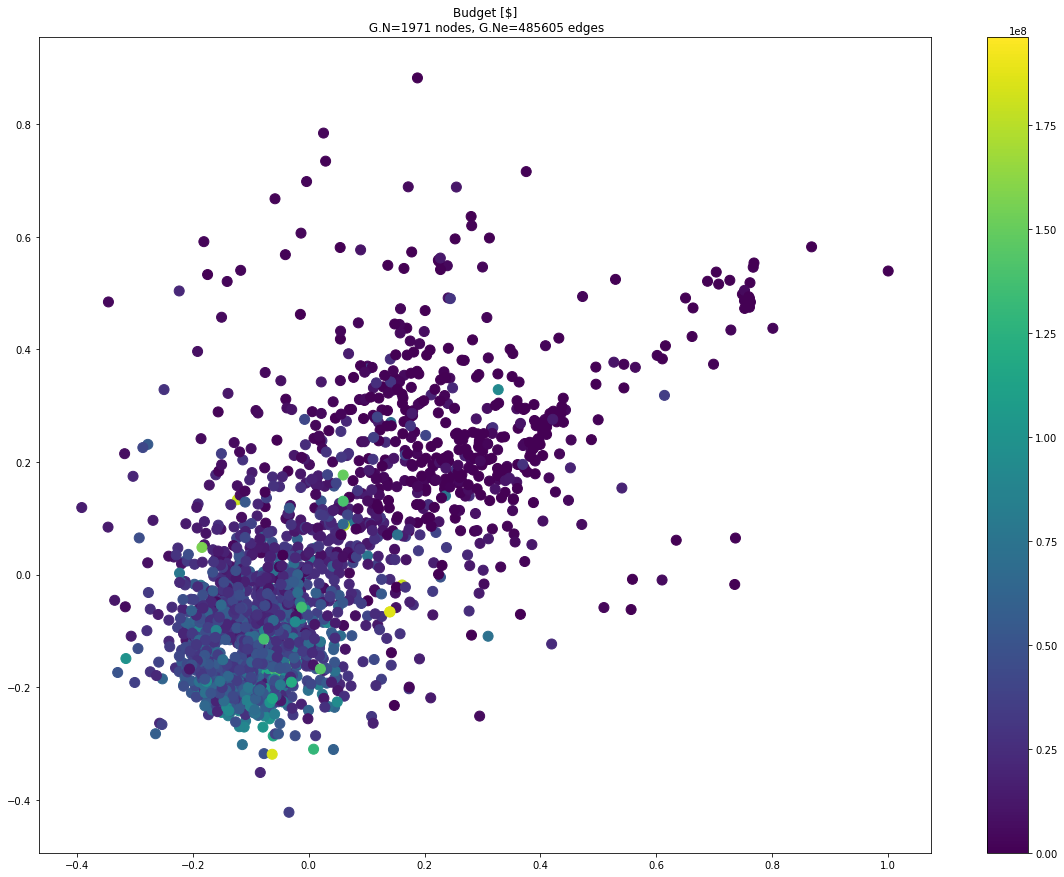

In [4]:
fig,ax = plt.subplots(figsize = (20,15))
G.plot_signal(budget_signal,ax=ax,plot_name = "Budget [$]\n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

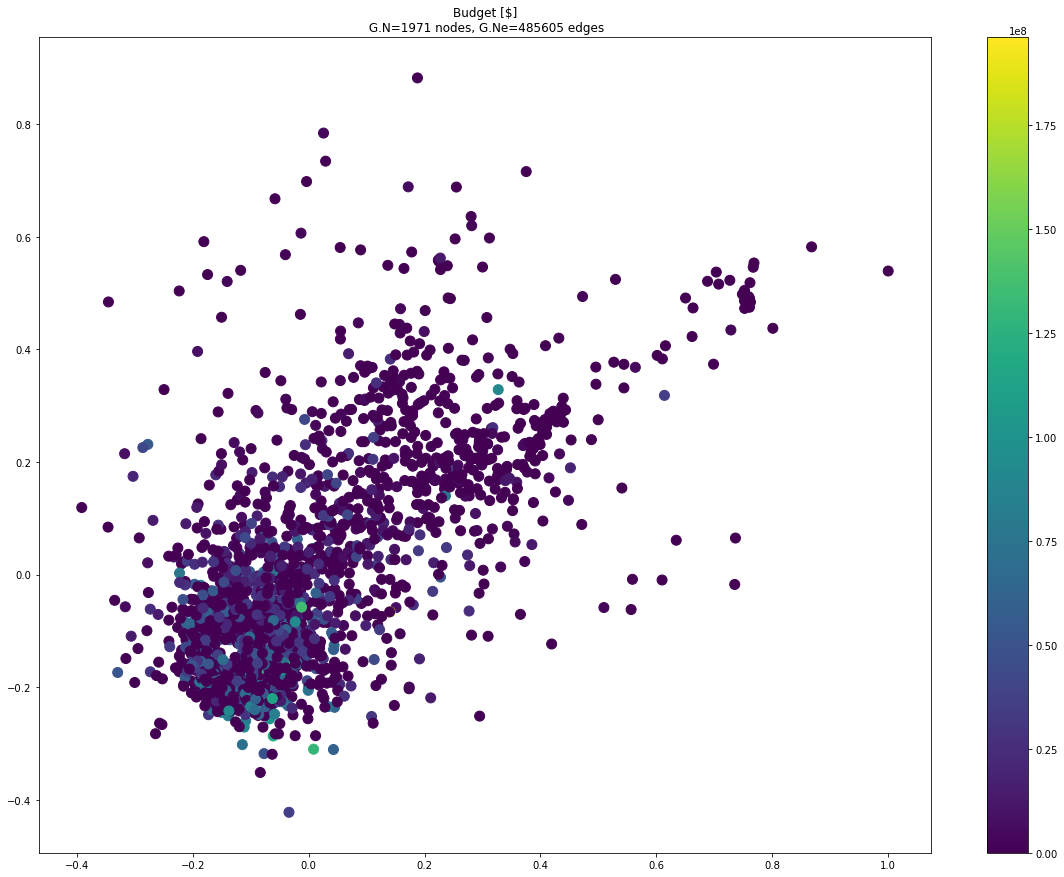

In [5]:
rs = np.random.RandomState(42)
M = rs.rand(G.N)
M = (M > 0.6).astype(float)

sigma = 0.1
subsampled_budget_signal = M * (budget_signal + sigma * rs.standard_normal(G.N))
fig,ax = plt.subplots(figsize = (20,15))
G.plot_signal(subsampled_budget_signal,ax=ax,plot_name = "Budget [$]\n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

In [6]:
gamma = 3.0
d = pyunlocbox.functions.dummy()
r = pyunlocbox.functions.norm_l1()
f = pyunlocbox.functions.norm_l2(w=M, y=subsampled_budget_signal,
                                  lambda_=gamma)
G.compute_differential_operator()
L = G.D.toarray()
step = 0.999 / (1 + np.linalg.norm(L))
solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

start_time = time.time()
x0 = subsampled_budget_signal.copy()
budget1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000)
print("---Solve operation took %s seconds ---" % (time.time() - start_time))

Solution found after 1000 iterations:
    objective function f(sol) = 2.456908e+10
    stopping criterion: MAXIT
---Solve operation took 5790.940811872482 seconds ---


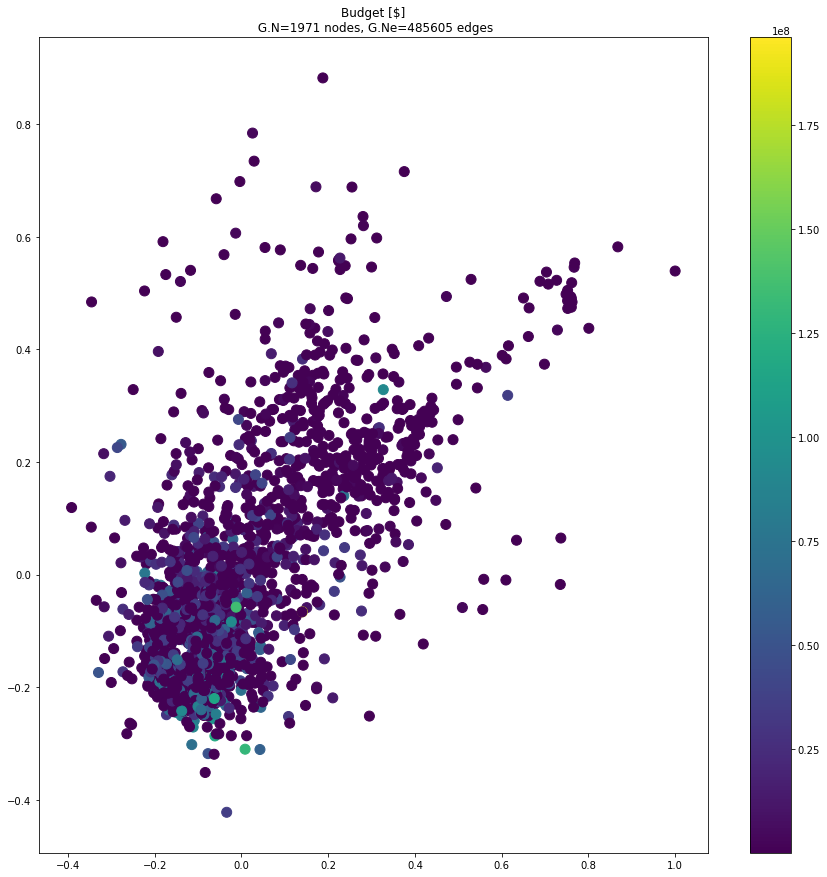

In [7]:
fig, ax = plt.subplots(figsize=(15,15))
G.plot_signal(budget1['sol'],ax=ax,plot_name = "Budget [$]\n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

In [8]:
budget_nmae = nmae(budget1['sol'],budget_signal,"range")
print("Normalized MAE budget: "+str(budget_nmae))

Normalized MAE budget: 0.10232951870014872


## Popularity signal

/Users/adrianvillarroel/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


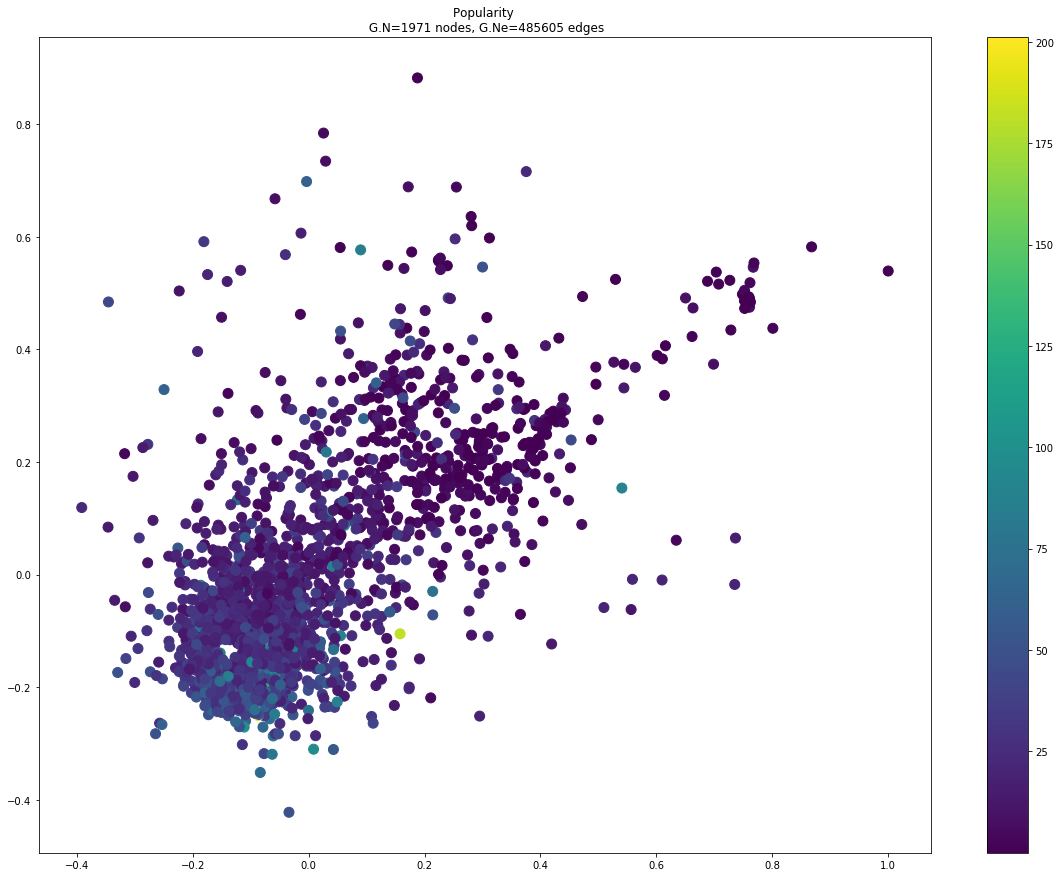

In [9]:
fig,ax = plt.subplots(figsize = (20,15))
G.plot_signal(popularity_signal,ax=ax,plot_name = "Popularity \n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

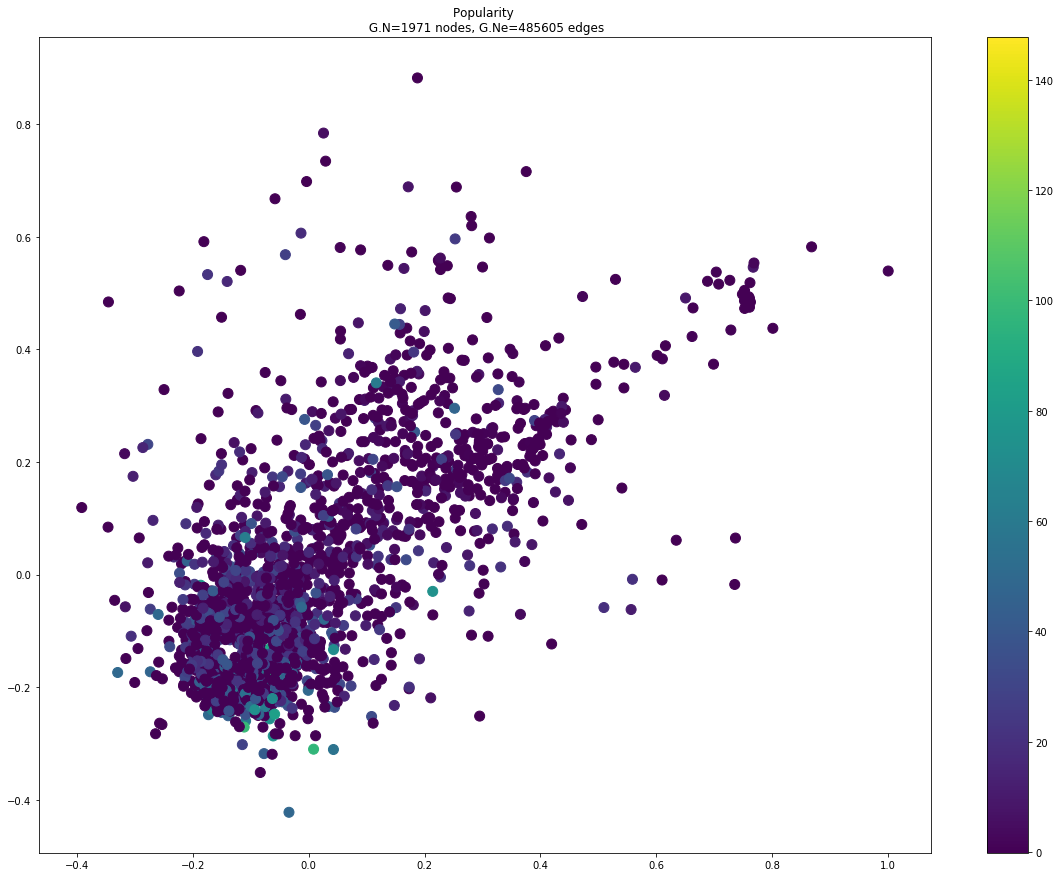

In [10]:
rs = np.random.RandomState(42)
M = rs.rand(G.N)
M = (M > 0.6).astype(float)

sigma = 0.1
subsampled_popularity_signal = M * (popularity_signal + sigma * rs.standard_normal(G.N))
fig,ax = plt.subplots(figsize = (20,15))
G.plot_signal(subsampled_popularity_signal,ax=ax,plot_name = "Popularity \n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

In [12]:
gamma = 3.0
d = pyunlocbox.functions.dummy()
r = pyunlocbox.functions.norm_l1()
f = pyunlocbox.functions.norm_l2(w=M, y=subsampled_popularity_signal,
                                  lambda_=gamma)
G.compute_differential_operator()
L = G.D.toarray()
step = 0.999 / (1 + np.linalg.norm(L))
solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

start_time = time.time()
x0 = subsampled_popularity_signal.copy()
popularity1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000)
print("---Solve operation took %s seconds ---" % (time.time() - start_time))

Solution found after 1000 iterations:
    objective function f(sol) = 1.614428e+05
    stopping criterion: MAXIT
---Solve operation took 2150.0158240795135 seconds ---


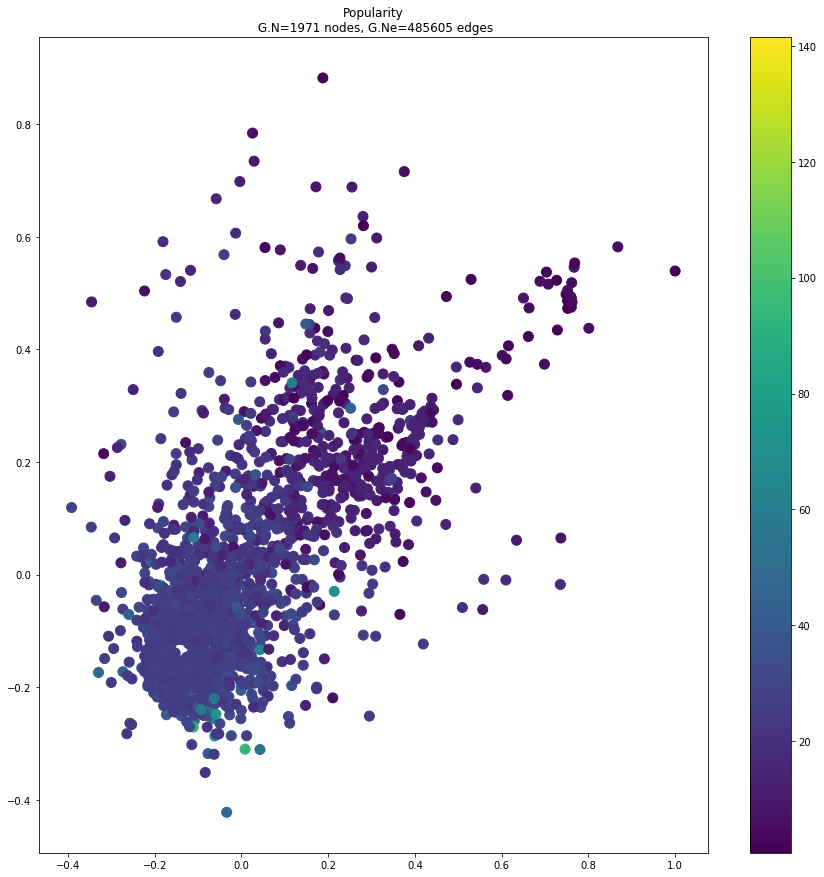

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
G.plot_signal(popularity1['sol'],ax=ax,plot_name = "Popularity\n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

In [14]:
popularity_nmae = nmae(popularity1['sol'],popularity_signal,"range")
print("Normalized MAE popularity: "+str(popularity_nmae))

Normalized MAE popularity: 0.06790013595051365


## Vote average signal

/Users/adrianvillarroel/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


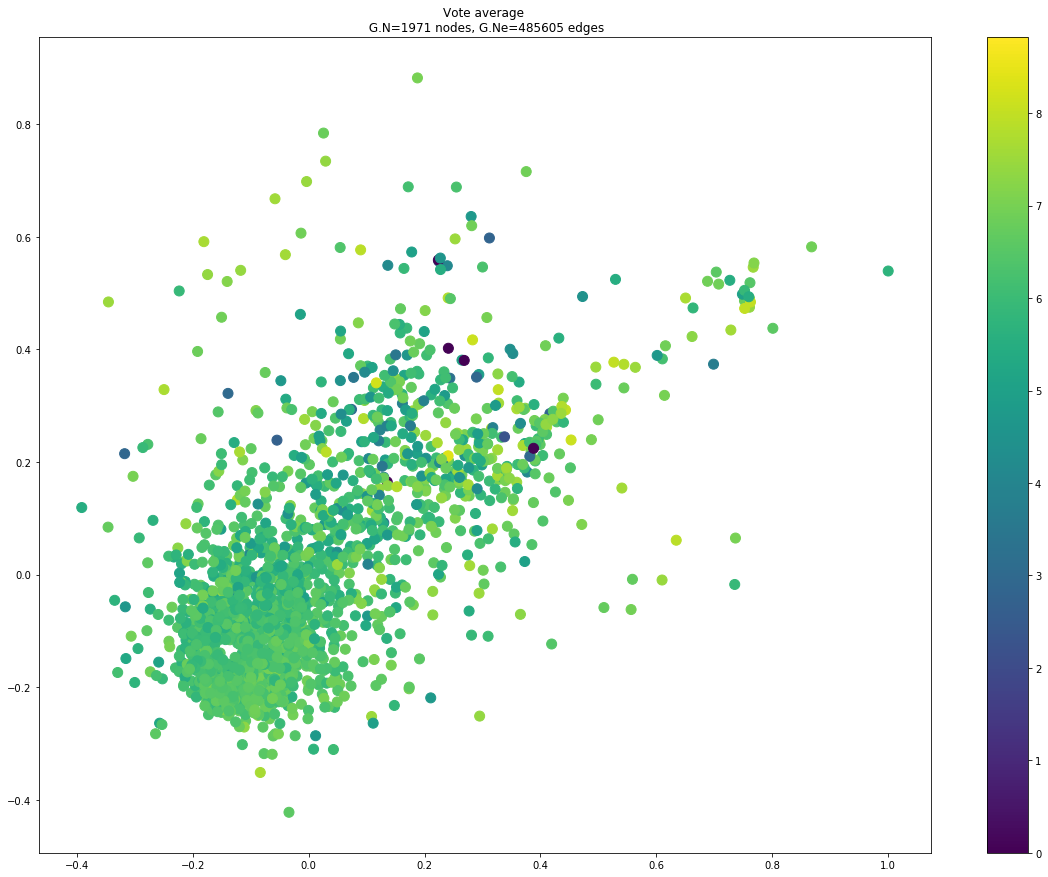

In [15]:
fig,ax = plt.subplots(figsize = (20,15))
G.plot_signal(vote_average_signal,ax=ax,plot_name = "Vote average \n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

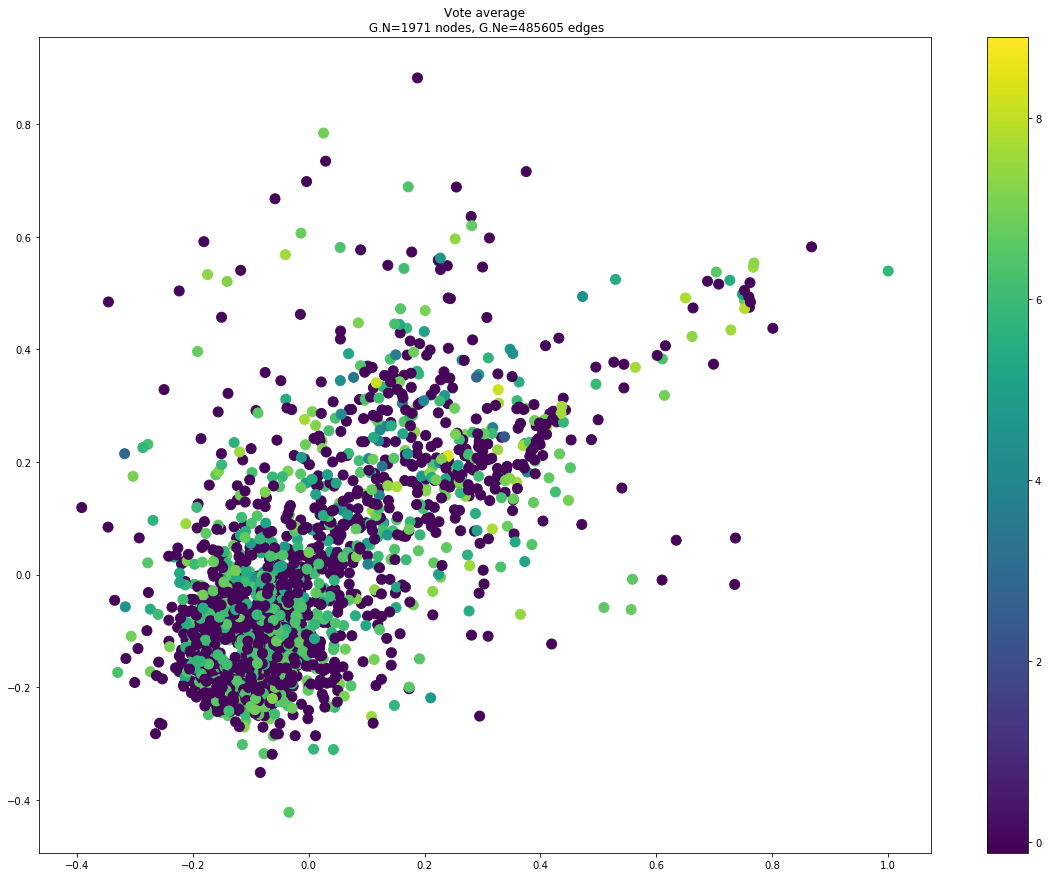

In [16]:
rs = np.random.RandomState(42)
M = rs.rand(G.N)
M = (M > 0.6).astype(float)

sigma = 0.1
subsampled_vote_average_signal = M * (vote_average_signal + sigma * rs.standard_normal(G.N))
fig,ax = plt.subplots(figsize = (20,15))
G.plot_signal(subsampled_vote_average_signal,ax=ax,plot_name = "Vote average\n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

In [17]:
gamma = 3.0
d = pyunlocbox.functions.dummy()
r = pyunlocbox.functions.norm_l1()
f = pyunlocbox.functions.norm_l2(w=M, y=subsampled_vote_average_signal,
                                  lambda_=gamma)
G.compute_differential_operator()
L = G.D.toarray()
step = 0.999 / (1 + np.linalg.norm(L))
solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

start_time = time.time()
x0 = subsampled_vote_average_signal.copy()
vote_average1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000)
print("---Solve operation took %s seconds ---" % (time.time() - start_time))

Solution found after 1000 iterations:
    objective function f(sol) = 1.336464e+04
    stopping criterion: MAXIT
---Solve operation took 1658.0538432598114 seconds ---


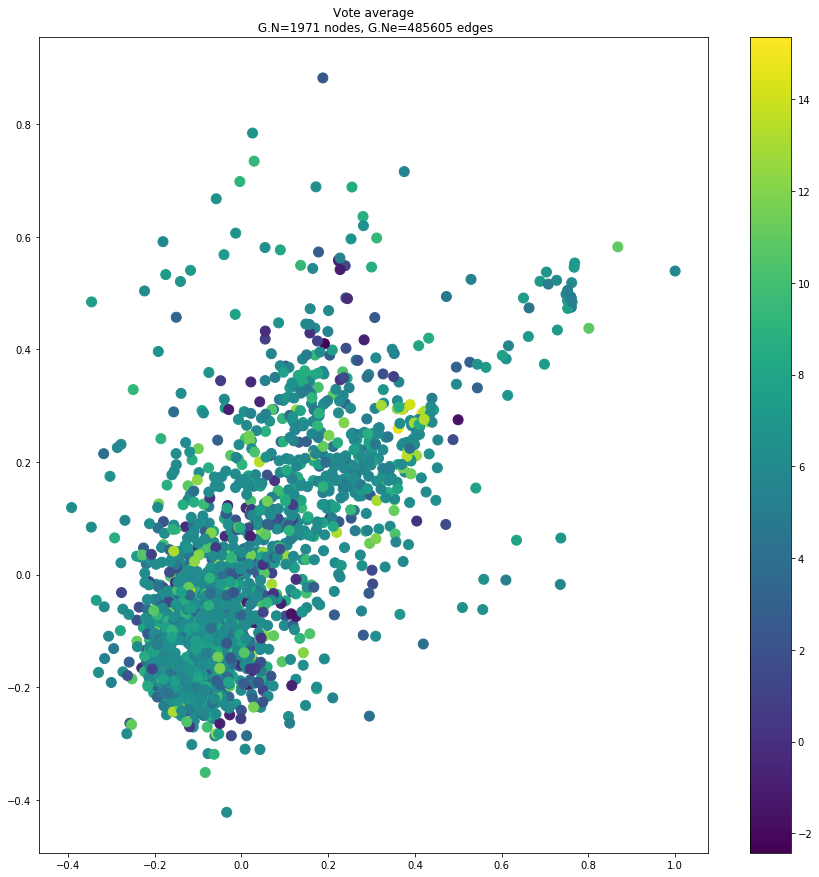

In [18]:
ig, ax = plt.subplots(figsize=(15,15))
G.plot_signal(vote_average1['sol'],ax=ax,plot_name = "Vote average\n G.N={:2d} nodes, G.Ne={:2d} edges".format(G.N,G.Ne))

In [19]:
vote_average_nmae = nmae(vote_average1['sol'],vote_average_signal,"range")
print("Normalized MAE vote_average: "+str(vote_average_nmae))

Normalized MAE vote_average: 0.09678970395523015
